<a href="https://colab.research.google.com/github/valeriezhang/ONGB/blob/main/DATA102_FINAL_PROJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data 102 Final Project

Setup and Data Upload

In [ ]:
import numpy as np
import seaborn as sns
import math
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving candidate_summary_2022.csv to candidate_summary_2022 (2).csv
Saving war-database.csv to war-database (2).csv
Saving rep_candidates.csv to rep_candidates (2).csv
Saving dem_candidates.csv to dem_candidates (2).csv
Saving fec-finance.csv to fec-finance (2).csv


In [ ]:
#load in all the csv's
dem = pd.read_csv("dem_candidates.csv")
rep = pd.read_csv("rep_candidates.csv")
war = pd.read_csv("war-database.csv")
fin = pd.read_csv("candidate_summary_2022.csv")

Checking Data Counts

In [ ]:
Sanders = (dem["Sanders"] == "Yes").sum()
print(Sanders)

Emily = (dem["EMILY's List"] == "Yes").sum()
print(Emily)

AOC = (dem["AOC"] == "Yes").sum()
print(Emily)

ind = (dem["Indivisible"] == "Yes").sum()
print(ind)

19
64
64
21


In [ ]:
Trump = (rep["Trump"] == "Yes").sum()
print(Trump)

Maggie = (rep["Maggie's List"] == "Yes").sum()
print(Maggie)

renew = (rep["Renew America"] == "Yes").sum()
print(renew)

club = (rep["Club for Growth"] == "Yes").sum()
print(club)

epac = (rep["E-PAC"] == "Yes").sum()
print(epac)

188
49
6
23
18


Data Cleaning and Normalization

In [ ]:
import re

def normalize_name(name):
    name = name.strip()

    if ',' in name:
        last, first_middle = name.split(',', 1)
        last = last.strip()
        first_middle = first_middle.strip()
        full_name = f"{first_middle} {last}"
    else:
        full_name = name

    full_name = re.sub(r'[^\w\s]', '', full_name)

    normalized = ' '.join(full_name.lower().split())

    return normalized



In [ ]:
dem_normalized = dem.copy()
dem_normalized['Candidate'] = dem_normalized['Candidate'].apply(normalize_name)
rep_normalize = rep.copy()
rep_normalize['Candidate'] = rep_normalize['Candidate'].apply(normalize_name)
fin_normalized = fin.copy()
fin_normalized['Cand_Name'] = fin_normalized['Cand_Name'].apply(normalize_name)

Data Merging

In [ ]:
fin_normalized = fin_normalized.rename(columns={"Cand_Name": "Candidate"})

dem_fin = pd.merge(dem_normalized, fin_normalized, on='Candidate', how='left')
rep_fin = pd.merge(rep_normalize, fin_normalized, on='Candidate', how='left')

dem_fin[dem_fin['Total_Receipt'] > 0 & dem_fin['Total_Receipt'].notnull()]['Total_Receipt']

,Total_Receipt
8,214285.69
11,42027.58
16,3532.00
20,5380.00
21,493221.73
...,...
1071,4449497.54
1073,1981382.79
1074,88392.23
1075,12000.00


WAR Data Processing

In [ ]:
#split the dataset from wide to long by democrat/republican
party_split = pd.melt(war, id_vars = ["Year", "Chamber", "Geography", "WAR", "Sortable"], value_vars=["Democrat", "Republican"], var_name="Party", value_name="Candidate")

party_split.head(5)

,Year,Chamber,Geography,WAR,Sortable,Party,Candidate
0,2024,House,AL-01,D+1.3,-1.30,Democrat,Tom Holmes
1,2024,House,AL-02,D+2.2,-2.17,Democrat,Shomari Figures
2,2024,House,AL-06,D+4.5,-4.47,Democrat,Elizabeth Anderson
3,2024,House,AL-07,R+0.2,0.15,Democrat,Terri Sewell
4,2024,House,AK-AL,D+9.1,-9.13,Democrat,Mary Peltola


In [ ]:
war_normalized = party_split.copy()
war_normalized['Candidate'] = war_normalized['Candidate'].apply(normalize_name)

dem_war_fin = pd.merge(dem_fin, war_normalized, on='Candidate', how='left')
rep_war_fin = pd.merge(rep_fin, war_normalized, on='Candidate', how='left')

dem_war_clean = dem_war_fin.dropna(subset=['Sortable']).copy()
rep_war_clean = rep_war_fin.dropna(subset=['Sortable']).copy()

dem_war_clean.head(5)

,Candidate,Gender,Race 1,Race 2,Race 3,Incumbent,Incumbent Challenger,State,Primary Date,Office,...,Net_Operating_Expenditure,Cash_On_Hand_BOP,Debt_Owe_To_Committee,Coverage_Start_Date,Year,Chamber,Geography,WAR,Sortable,Party
4,robin fulford,Female,White,NaN,NaN,No,No,Texas,3/1/22,Representative,...,NaN,NaN,NaN,NaN,2022.0,House,TX-02,D+2.8,-2.80,Democrat
6,sandeep srivastava,Male,Asian (Indian),NaN,NaN,No,No,Texas,3/1/22,Representative,...,NaN,NaN,NaN,NaN,2024.0,House,TX-03,R+1,0.97,Democrat
7,sandeep srivastava,Male,Asian (Indian),NaN,NaN,No,No,Texas,3/1/22,Representative,...,NaN,NaN,NaN,NaN,2022.0,House,TX-03,R+0.6,0.60,Democrat
8,iro omere,Female,Black,NaN,NaN,No,No,Texas,3/1/22,Representative,...,NaN,NaN,NaN,NaN,2022.0,House,TX-04,D+0.3,-0.30,Democrat
10,tartisha hill,Female,Black,NaN,NaN,No,No,Texas,3/1/22,Representative,...,NaN,NaN,NaN,NaN,2022.0,House,TX-05,D+2.5,-2.50,Democrat


Feature Engineering

In [ ]:
#Preparing Random Forest
dem_war_clean["result"] = dem_war_clean["Primary Outcome"].apply(lambda x: 1 if x == "Won" else 0)
rep_war_clean["result"] = rep_war_clean["Primary Outcome"].apply(lambda x: 1 if x == "Won" else 0)

all_candidates = pd.concat([dem_war_clean, rep_war_clean])

features = ["Gender", "Ethnicity", "Incumbent", "Total_Receipt"] #gotta figure how to do endorsements


endorsement_cols = ['Sanders', 'AOC', "EMILY's List", 'Justice Dems', 'Indivisible', 'PCCC', 'Our Revolution', 'Sunrise', 'Sanders', 'AOC', 'Trump', 'Club for Growth', 'Renew America', 'E-PAC', 'VIEW PAC', "Maggie's List", 'Winning for Women']

# One-hot encode: 1 if endorsed, 0 if not
for col in endorsement_cols:
    all_candidates[f'{col}_endorsed'] = all_candidates[col].notna().astype(int)

all_candidates.columns

Index(['Candidate', 'Gender', 'Race 1', 'Race 2', 'Race 3', 'Incumbent',
       'Incumbent Challenger', 'State', 'Primary Date', 'Office',
       ...
       'PCCC_endorsed', 'Our Revolution_endorsed', 'Sunrise_endorsed',
       'Trump_endorsed', 'Club for Growth_endorsed', 'Renew America_endorsed',
       'E-PAC_endorsed', 'VIEW PAC_endorsed', 'Maggie's List_endorsed',
       'Winning for Women_endorsed'],
      dtype='object', length=106)

Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# all relevant features
X_cols = ["Gender", 'Race 1', 'Race 2', 'Race 3', "Incumbent", 'Total_Receipt',
          'Sanders_endorsed', 'AOC_endorsed', "EMILY's List_endorsed", 'Justice Dems_endorsed',
          'Indivisible_endorsed', 'PCCC_endorsed', 'Our Revolution_endorsed', 'Sunrise_endorsed',
          'Trump_endorsed', 'Club for Growth_endorsed', 'Renew America_endorsed', 'E-PAC_endorsed',
          'VIEW PAC_endorsed', "Maggie's List_endorsed", 'Winning for Women_endorsed']

y_col = 'result'


# split
X = all_candidates[X_cols]
y = all_candidates[y_col]

X = pd.get_dummies(X, drop_first=True)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train
model_forest = RandomForestClassifier(random_state=42)
model_forest.fit(X_train, y_train)

# predictions
probs_forest = model_forest.predict_proba(X_test)[:, 1]
y_hat_forest = (probs_forest > 0.5).astype(int)

# accuracy
accuracy = accuracy_score(y_test, y_hat_forest)
print(f"Accuracy on test set: {accuracy:.3f}")

Accuracy on test set: 0.924


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat_forest))

              precision    recall  f1-score   support

           0       0.63      0.28      0.39        43
           1       0.94      0.98      0.96       454

    accuracy                           0.92       497
   macro avg       0.78      0.63      0.67       497
weighted avg       0.91      0.92      0.91       497



In [ ]:
##next steps:
model = RandomForestClassifier(class_weight='balanced')

In [ ]:
#check imbalance
print(y_train.value_counts()) #train
print(y_test.value_counts()) #test

result
1    1048
0     111
Name: count, dtype: int64
result
1    454
0     43
Name: count, dtype: int64


In [ ]:
balanced_model = RandomForestClassifier(random_state=42, class_weight='balanced')
balanced_model.fit(X_train, y_train)
y_pred_balanced = balanced_model.predict(X_test)

print(classification_report(y_test, y_pred_balanced))

              precision    recall  f1-score   support

           0       0.30      0.56      0.39        43
           1       0.95      0.88      0.92       454

    accuracy                           0.85       497
   macro avg       0.63      0.72      0.65       497
weighted avg       0.90      0.85      0.87       497



In [ ]:
#try oversampling the losers to balance data
from sklearn.utils import resample

winners = all_candidates[all_candidates['result'] == 1]
losers = all_candidates[all_candidates['result'] == 0]

losers_oversampled = resample(losers, replace=True, n_samples=len(winners), random_state=42)
balanced_data = pd.concat([winners, losers_oversampled])

X = balanced_data[X_cols]
y = balanced_data[y_col]

X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       443
           1       0.95      0.88      0.91       459

    accuracy                           0.92       902
   macro avg       0.92      0.92      0.92       902
weighted avg       0.92      0.92      0.92       902



In [ ]:
importances = model.feature_importances_
features = X.columns
pd.DataFrame({"Feature":features, "Importance":importances}).sort_values("Importance", ascending=False).head(10)

,Feature,Importance
0,Total_Receipt,0.386374
61,Incumbent_Yes,0.212396
16,Gender_Male,0.038671
11,Renew America_endorsed,0.034952
9,Trump_endorsed,0.030218
10,Club for Growth_endorsed,0.028420
13,VIEW PAC_endorsed,0.023110
52,Race 1_White,0.022312
14,Maggie's List_endorsed,0.021767
12,E-PAC_endorsed,0.019697


In [ ]:
print(dem.columns)

Index(['Candidate', 'Gender', 'Race 1', 'Race 2', 'Race 3', 'Incumbent',
       'Incumbent Challenger', 'State', 'Primary Date', 'Office', 'District',
       'Primary Votes', 'Primary %', 'Primary Outcome', 'Runoff Votes',
       'Runoff %', 'Runoff Outcome', 'EMILY's List', 'Justice Dems',
       'Indivisible', 'PCCC', 'Our Revolution', 'Sunrise', 'Sanders', 'AOC',
       'Party Committee'],
      dtype='object')


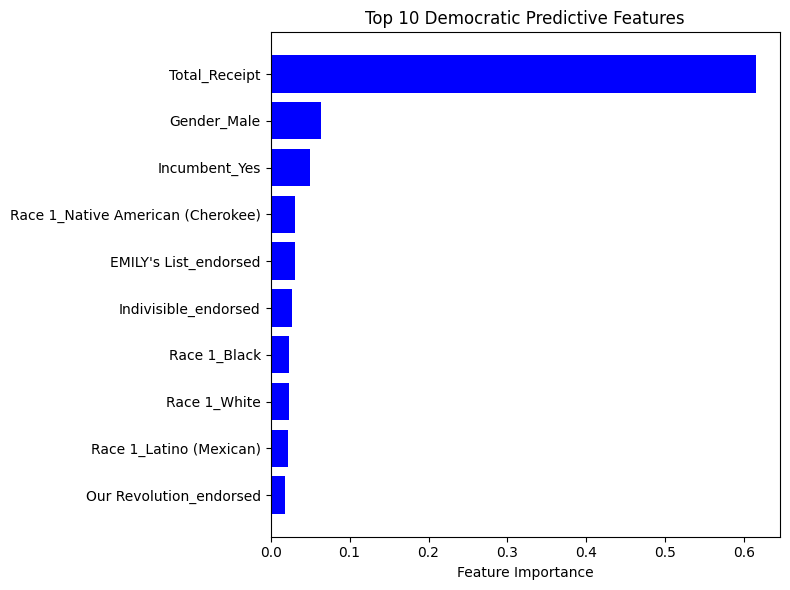

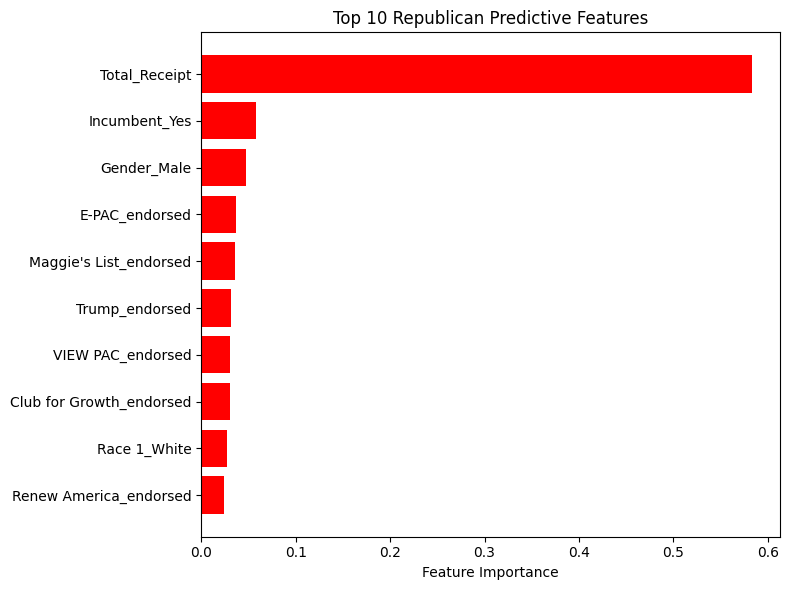

In [ ]:
# Prepare the data - same as in logistic regression example
dem['result'] = dem['Primary Outcome'].apply(lambda x: 1 if x == 'Won' else 0)
rep['result'] = rep['Primary Outcome'].apply(lambda x: 1 if x == 'Won' else 0)


def run_party_random_forest(df, endorsement_cols):
    df = df[df['Total_Receipt'].notna()].copy()

    features = ['Incumbent', 'Gender', 'Race 1', 'Total_Receipt']
    X = df[features + endorsement_cols].copy()
    y = df['result']

    for col in endorsement_cols:
        X[f'{col}_endorsed'] = df[col].notna().astype(int)
        X.drop(columns=col, inplace=True)

    X = pd.get_dummies(X, columns=['Incumbent', 'Gender', 'Race 1'], drop_first=True)

    model = RandomForestClassifier(random_state=42)
    model.fit(X, y)

    importances = pd.Series(model.feature_importances_, index=X.columns)
    return model, importances.sort_values(ascending=False)

dem_endorsements = ['Sanders', 'AOC', "EMILY's List", 'Justice Dems', 'Indivisible',
                    'PCCC', 'Our Revolution', 'Sunrise']
rep_endorsements = ['Trump', 'Club for Growth', 'Renew America', 'E-PAC', 'VIEW PAC',
                   "Maggie's List", 'Winning for Women']

dem_model, dem_importances = run_party_random_forest(dem_war_clean, dem_endorsements)
rep_model, rep_importances = run_party_random_forest(rep_war_clean, rep_endorsements)

dem_df = dem_importances.head(10).reset_index()
dem_df.columns = ['Feature', 'Importance']

rep_df = rep_importances.head(10).reset_index()
rep_df.columns = ['Feature', 'Importance']

def plot_top_features(df, title, color):
    plt.figure(figsize=(8, 6))
    plt.barh(df['Feature'], df['Importance'], color=color)
    plt.title(title)
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.gca().invert_yaxis()  # Highest importance at top
    plt.show()

plot_top_features(dem_df, 'Top 10 Democratic Predictive Features', 'blue')
plot_top_features(rep_df, 'Top 10 Republican Predictive Features', 'red')

Logistic Regression Model

Log-Liklihood for Republican Party Model: -31.040288425796888
AIC for Republican Party Model: 1062.0805768515938
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
Republican Party Accuracy: 0.9266666666666666
Republican Party Precision: 0.9266666666666666
Republican Party Recall: 1.0
Log-Liklihood for Republican Party Model: -41.601615811454856
AIC for Republican Party Model: 1001.2032316229097
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Republican Party Accuracy: 0.8768115942028986
Republican Party Pr

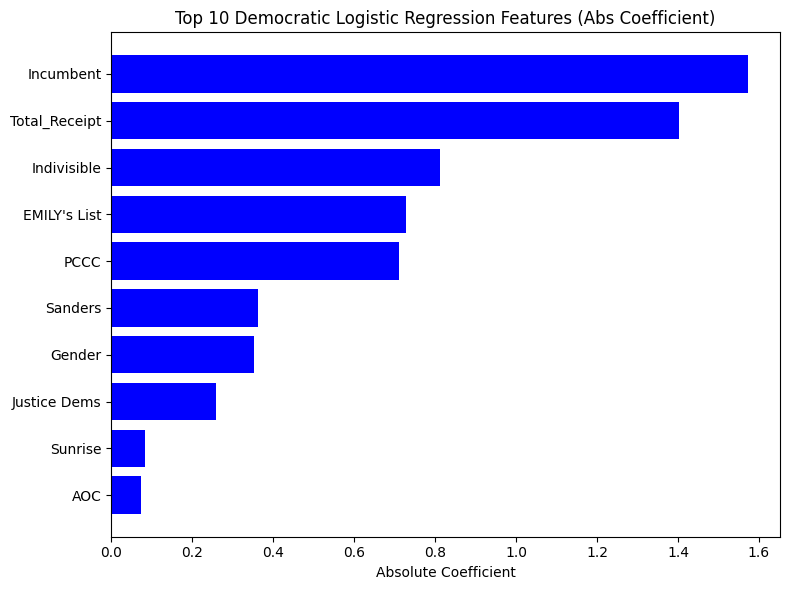

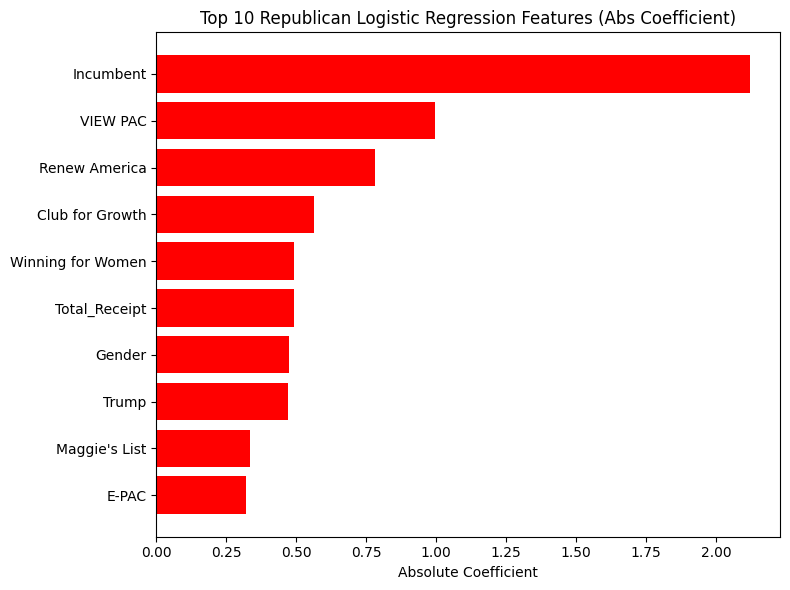

array([[ 1.57339884, -0.35228689,  0.03290988,  1.40171904, -0.36299373,
        -0.07392989, -0.72914244,  0.25779182, -0.81103225, -0.71066228,
         0.00268127,  0.08304412]])

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt


dem['result'] = dem['Primary Outcome'].apply(lambda x: 1 if x == 'Won' else 0)
rep['result'] = rep['Primary Outcome'].apply(lambda x: 1 if x == 'Won' else 0)

def run_party_logistic_regression(df, endorsement_cols):
    df = df[df['Total_Receipt'].notna()].copy()

    features = ['Incumbent', 'Gender', 'Race 1', 'Total_Receipt']
    X = df[features + endorsement_cols].copy()
    y = df['result']

    for col in endorsement_cols:
        X[f'{col}'] = df[col].notna().astype(int)

    X['Incumbent'] = X['Incumbent'].astype('category').cat.codes
    X['Gender'] = X['Gender'].astype('category').cat.codes
    X['Race 1'] = X['Race 1'].astype('category').cat.codes

    scaler = StandardScaler()
    X['Total_Receipt'] = scaler.fit_transform(X[['Total_Receipt']])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)

    log_prob = model.predict_log_proba(X_test)
    log_liklihood = log_prob[np.arange(len(y_test)), y_test].sum()
    print(f"Log-Liklihood for Republican Party Model: {log_liklihood}")

    k = len(X)
    aic = (2*k) - (2*log_liklihood)
    print(f"AIC for Republican Party Model: {aic}")

    y_pred = model.predict(X_test)
    print(y_pred)
    print(f"Republican Party Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Republican Party Precision: {precision_score(y_test, y_pred)}")
    print(f"Republican Party Recall: {recall_score(y_test, y_pred)}")
    return model.coef_

dem_endorsements = ['Sanders', 'AOC', "EMILY's List", 'Justice Dems', 'Indivisible', 'PCCC',
                    'Our Revolution', 'Sunrise']
rep_endorsements = ['Trump', 'Club for Growth', 'Renew America', 'E-PAC', 'VIEW PAC',
                    "Maggie's List", 'Winning for Women']

dem_coefficients = run_party_logistic_regression(dem_war_clean, dem_endorsements)
rep_coefficients = run_party_logistic_regression(rep_war_clean, rep_endorsements)
print("Democratic Model Coefficients:\n", dem_coefficients)
print("\nRepublican Model Coefficients:\n", rep_coefficients)

dem_coefficients_series = pd.Series(dem_coefficients[0], index=['Incumbent', 'Gender', 'Race 1', 'Total_Receipt'] + dem_endorsements)
dem_df = abs(dem_coefficients_series).sort_values(ascending=False).head(10).reset_index()
dem_df.columns = ['Feature', 'Abs Coefficient']
rep_coefficients_series = pd.Series(rep_coefficients[0], index=['Incumbent', 'Gender', 'Race 1', 'Total_Receipt'] + rep_endorsements)
rep_df = abs(rep_coefficients_series).sort_values(ascending=False).head(10).reset_index()
rep_df.columns = ['Feature', 'Abs Coefficient']

def plot_top_coefficients(df, title, color):
    plt.figure(figsize=(8, 6))
    plt.barh(df['Feature'], df['Abs Coefficient'], color=color)
    plt.title(title)
    plt.xlabel('Absolute Coefficient')
    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.show()

plot_top_coefficients(dem_df, 'Top 10 Democratic Logistic Regression Features (Abs Coefficient)', color='blue')
plot_top_coefficients(rep_df, 'Top 10 Republican Logistic Regression Features (Abs Coefficient)', color='red')
dem_coefficients

Propensity Score Matching

In [ ]:
#listing confounders
confounders = [['State', 'Gender', 'Chamber', 'Race 1', 'Incumbent', 'Total_Receipt']]

In [ ]:
def has_endorsement(row):
  if row['Party'] == 'Democrat':
    if row["Sanders_endorsed"] == 1 or row["AOC_endorsed"] == 1 or row["EMILY's List_endorsed"] == 1:
          return 1
    else:
          return 0
  else:
        if row["Trump_endorsed"] == 1 or row["Maggie's List_endorsed"] == 1 or row["Renew America_endorsed"] == 1:
          return 1
        else:
          return 0

In [ ]:
all_candidates['has_endorsement']= all_candidates.apply(has_endorsement, axis=1)

In [ ]:
#total number
total_num = len(all_candidates)

#number with endorsement
num_endorsed = len(all_candidates[all_candidates['has_endorsement'] == 1])

#number dems
num_dems = len(all_candidates[all_candidates['Party'] == 'Democrat'])

#number dems with endorsement
num_endors_dems = len(all_candidates[(all_candidates['has_endorsement'] == 1) & (all_candidates['Party'] == 'Democrat')])


#number reps
num_reps = len(all_candidates[all_candidates['Party'] == 'Republican'])

#number reps with endorsement
num_rep_endorse = len(all_candidates[(all_candidates['has_endorsement'] == 1) & (all_candidates['Party'] == 'Republican')])

print(total_num)
print(num_endorsed)
print(num_dems)
print(num_endors_dems)
print(num_reps)
print(num_rep_endorse)

1656
639
760
147
896
492


In [ ]:
#NEW
confounders = ['Incumbent', 'Gender', 'Race 1', 'State', 'Total_Receipt', 'Chamber']

all_candidates = all_candidates.dropna(subset=['Total_Receipt'])

categorical = ['Incumbent', 'Gender', 'Race 1', 'State',  'Chamber']
continuous = ['Total_Receipt']
X = all_candidates[confounders].copy()
X = pd.get_dummies(X, columns=categorical, drop_first=True)
y = all_candidates['has_endorsement']

In [ ]:
print(X.head())

    Total_Receipt  Incumbent_Yes  Gender_Male  Race 1_Asian (Bangladeshi)  \
15       42027.58          False        False                       False   
16       42027.58          False        False                       False   
30     2346631.22          False        False                       False   
31     2346631.22          False        False                       False   
33     1295134.87           True        False                       False   

    Race 1_Asian (Chinese)  Race 1_Asian (Filipino)  Race 1_Asian (Indian)  \
15                   False                    False                  False   
16                   False                    False                  False   
30                   False                    False                  False   
31                   False                    False                  False   
33                   False                    False                  False   

    Race 1_Asian (Japanese)  Race 1_Asian (Korean)  Race 1_Asian (Ta

In [ ]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X, y)
all_candidates['propensity_score'] = log_reg.predict_proba(X)[:, 1]

In [ ]:
len(all_candidates)

959

In [ ]:
print(all_candidates['propensity_score'].describe())

count    959.000000
mean       0.366023
std        0.057129
min        0.298522
25%        0.326152
50%        0.350286
75%        0.394334
max        0.966633
Name: propensity_score, dtype: float64


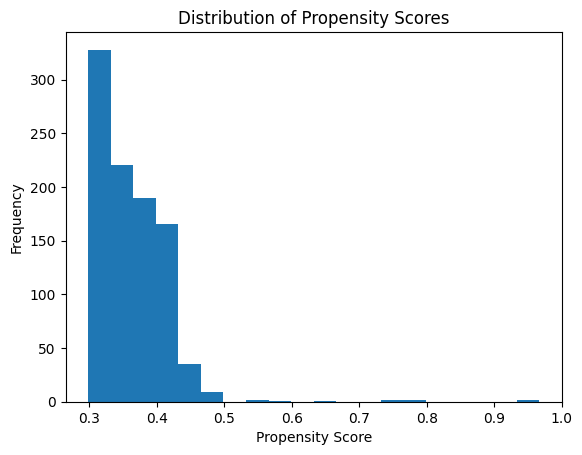

In [ ]:
plt.hist(all_candidates['propensity_score'], bins=20)
plt.xlabel("Propensity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Propensity Scores")
plt.show()

In [ ]:
from sklearn.neighbors import NearestNeighbors
treated = all_candidates[all_candidates['has_endorsement'] == 1] #endorsements
untreated = all_candidates[all_candidates['has_endorsement'] == 0] #non endorsements

#match the most similar non-endorsed candidates based on the propensity score
nbrs = NearestNeighbors(n_neighbors=1).fit(untreated[['propensity_score']])
nbrs.fit(untreated[["propensity_score"]])
distances, indices = nbrs.kneighbors(treated[['propensity_score']])
matched_untreated = untreated.iloc[indices.flatten()]

In [ ]:
all_candidates['contentiousness'] = abs(all_candidates['Sortable']) #defined as how much the election result differed from expectations

treated = all_candidates[all_candidates['has_endorsement'] == 1]
matched_untreated = all_candidates[all_candidates['has_endorsement'] == 0]

treated_cont = treated['contentiousness'].mean()
control_cont = matched_untreated['contentiousness'].mean()
causal_effect = treated_cont - control_cont

print("Endorsed contentiousness:", treated_cont)
print("Non-endorsed contentiousness:", control_cont)
print("Causal effect:", causal_effect)

from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(treated['contentiousness'], matched_untreated['contentiousness'])
print(f"p-value: {p_value:.4f}")

Endorsed contentiousness: 3.396011235955056
Non-endorsed contentiousness: 3.228922056384743
Causal effect: 0.1670891795703131
p-value: 0.4103


Validating Model with Specific Variables

In [ ]:
#validating the causal model with other variabels
#gender
confounders = ['Incumbent', 'has_endorsement', 'Race 1', 'State', 'Total_Receipt', 'Chamber']

all_candidates = all_candidates.dropna(subset=['Total_Receipt'])

categorical = ['Incumbent', 'has_endorsement', 'Race 1', 'State',  'Chamber']
continuous = ['Total_Receipt']
X = all_candidates[confounders].copy()
X = pd.get_dummies(X, columns=categorical, drop_first=True)
y = (all_candidates['Gender'] == 'Female').astype(int)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X, y)
all_candidates['propensity_score2'] = log_reg.predict_proba(X)[:, 1]

from sklearn.neighbors import NearestNeighbors
treated = all_candidates[all_candidates['Gender'] == 'Female']
untreated = all_candidates[all_candidates['Gender'] == 'Male']

#match the most similar non-endorsed candidates based on the propensity score
nbrs = NearestNeighbors(n_neighbors=1).fit(untreated[['propensity_score2']])
nbrs.fit(untreated[["propensity_score2"]])
distances, indices = nbrs.kneighbors(treated[['propensity_score2']])
matched_untreated = untreated.iloc[indices.flatten()]

all_candidates['contentiousness'] = abs(all_candidates['Sortable']) #defined as how much the election result differed from expectations

treated = all_candidates[all_candidates['Gender'] == 'Female']
matched_untreated = all_candidates[all_candidates['Gender'] == 'Male']

treated_cont = treated['contentiousness'].mean()
control_cont = matched_untreated['contentiousness'].mean()
causal_effect = treated_cont - control_cont

print("Female contentiousness:", treated_cont)
print("Male contentiousness:", control_cont)
print("Causal effect:", causal_effect)



from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(treated['contentiousness'], matched_untreated['contentiousness'])
print(f"p-value: {p_value:.4f}")


Female contentiousness: 3.4927837837837834
Male contentiousness: 3.1641595925297117
Causal effect: 0.3286241912540717
p-value: 0.1026


In [ ]:
#validating the causal model with other variabels
#incumbent
confounders = ['Gender', 'has_endorsement', 'Race 1', 'State', 'Total_Receipt', 'Chamber']

all_candidates = all_candidates.dropna(subset=['Total_Receipt'])

categorical = ['Gender', 'has_endorsement', 'Race 1', 'State',  'Chamber']
continuous = ['Total_Receipt']
X = all_candidates[confounders].copy()
X = pd.get_dummies(X, columns=categorical, drop_first=True)
y = (all_candidates['Incumbent'] == 'Yes').astype(int)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X, y)
all_candidates['propensity_score3'] = log_reg.predict_proba(X)[:, 1]

from sklearn.neighbors import NearestNeighbors
treated = all_candidates[all_candidates['Incumbent'] == 'Yes']
untreated = all_candidates[all_candidates['Incumbent'] == 'No']

#match the most similar non-endorsed candidates based on the propensity score
nbrs = NearestNeighbors(n_neighbors=1).fit(untreated[['propensity_score3']])
nbrs.fit(untreated[["propensity_score3"]])
distances, indices = nbrs.kneighbors(treated[['propensity_score3']])
matched_untreated = untreated.iloc[indices.flatten()]

all_candidates['contentiousness'] = abs(all_candidates['Sortable']) #defined as how much the election result differed from expectations

treated = all_candidates[all_candidates['Incumbent'] == 'Yes']
matched_untreated = all_candidates[all_candidates['Incumbent'] == 'No']

treated_cont = treated['contentiousness'].mean()
control_cont = matched_untreated['contentiousness'].mean()
causal_effect = treated_cont - control_cont

print("Incumbent contentiousness:", treated_cont)
print("Non-incumbent contentiousness:", control_cont)
print("Causal effect:", causal_effect)



from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(treated['contentiousness'], matched_untreated['contentiousness'])
print(f"p-value: {p_value:.4f}")


Incumbent contentiousness: 3.464358974358974
Non-incumbent contentiousness: 3.0616949152542374
Causal effect: 0.4026640591047368
p-value: 0.0418


In [ ]:
#validating the causal model with other variabels
#race
confounders = ['Incumbent', 'has_endorsement', 'Gender', 'State', 'Total_Receipt', 'Chamber']

all_candidates = all_candidates.dropna(subset=['Total_Receipt'])

categorical = ['Incumbent', 'has_endorsement', 'State', 'Gender', 'Chamber']
continuous = ['Total_Receipt']
X = all_candidates[confounders].copy()
X = pd.get_dummies(X, columns=categorical, drop_first=True)
y = (all_candidates['Race 1'] == 'White').astype(int)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X, y)
all_candidates['propensity_score2'] = log_reg.predict_proba(X)[:, 1]

from sklearn.neighbors import NearestNeighbors
treated = all_candidates[all_candidates['Race 1'] == 'White']
untreated = all_candidates[all_candidates['Race 1'] != 'White']

#match the most similar non-endorsed candidates based on the propensity score
nbrs = NearestNeighbors(n_neighbors=1).fit(untreated[['propensity_score2']])
nbrs.fit(untreated[["propensity_score2"]])
distances, indices = nbrs.kneighbors(treated[['propensity_score2']])
matched_untreated = untreated.iloc[indices.flatten()]

all_candidates['contentiousness'] = abs(all_candidates['Sortable']) #defined as how much the election result differed from expectations

treated = all_candidates[all_candidates['Race 1'] == 'White']
matched_untreated = all_candidates[all_candidates['Race 1'] != 'White']


treated_cont = treated['contentiousness'].mean()
control_cont = matched_untreated['contentiousness'].mean()
causal_effect = treated_cont - control_cont

print("White contentiousness:", treated_cont)
print("Non-white contentiousness:", control_cont)
print("Causal effect:", causal_effect)



from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(treated['contentiousness'], matched_untreated['contentiousness'])
print(f"p-value: {p_value:.4f}")


White contentiousness: 3.236811377245509
Non-white contentiousness: 3.4152233676975947
Causal effect: -0.17841199045208578
p-value: 0.4028


Thank you guys for this semester! We did our best in this project and we appreciate all the lessons we have learned in this course. Thank you to all the course staff and we hope all goes well!